## HW3: Decision Tree and Random Forest
In hw3, you need to implement decision tree and random forest by using only numpy, then train your implemented model by the provided dataset and test the performance with testing data

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling sklearn.tree.DecisionTreeClassifier

## Load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer

In [2]:
data = load_breast_cancer()
feature_names = data['feature_names']
print(feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [3]:
x_train = pd.read_csv("x_train.csv")
y_train = pd.read_csv("y_train.csv")
x_test = pd.read_csv("x_test.csv")
y_test = pd.read_csv("y_test.csv")

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 7 of hw3 slides](https://docs.google.com/presentation/d/1ish3jEr_6be0FK4kgOZa12nYAyJFh0P2LCNsNPOCiXo/edit#slide=id.g7703d1636d_0_21)

In [4]:
def gini(sequence):
    N = len(sequence)
    total_count = np.asarray(np.unique(sequence, return_counts=True)).T
    gini_value = 1
    for each_class, each_count in total_count:
        proportion = (each_count / N) ** 2
        gini_value -= proportion
    return gini_value

def entropy(sequence):
    N = len(sequence)
    total_count = np.asarray(np.unique(sequence, return_counts=True)).T
    entropy_value = 0
    for each_class, each_count in total_count:
        proportion = (each_count / N)
        entropy_value -= np.log2(proportion) * proportion
    return entropy_value

In [5]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [6]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [7]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the test data. You should implement two arguments for the Decision Tree algorithm
1. **Criterion**: The function to measure the quality of a split. Your model should support “gini” for the Gini impurity and “entropy” for the information gain. 
2. **Max_depth**: The maximum depth of the tree. If Max_depth=None, then nodes are expanded until all leaves are pure. Max_depth=1 equals to split data once


In [8]:
class Question():
    def __init__(self, feature, value):
        self.feature = feature
        self.value = value

In [9]:
class Decision_Node:
    def __init__(self, question, true_branch, false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

In [10]:
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None):
        self.criterion = criterion
        self.max_depth = max_depth

    def gini(self, sequence):
        N = len(sequence)
        total_count = np.asarray(np.unique(sequence, return_counts=True)).T
        gini_value = 1
        for each_class, each_count in total_count:
            proportion = (each_count / N) ** 2
            gini_value -= proportion
        return gini_value

    def entropy(self, sequence):
        N = len(sequence)
        total_count = np.asarray(np.unique(sequence, return_counts=True)).T
        entropy_value = 0
        for each_class, each_count in total_count:
            proportion = (each_count / N)
            entropy_value -= np.log2(proportion) * proportion
        return entropy_value

    def find_best_split(self, X, y):
        best_purity = 1e5
        best_question = None
        for feature_idx in range(X.shape[1]):
            unique_values = np.unique(X[:, feature_idx])
            for candidate_value in unique_values:
                current_question = Question(feature=feature_idx,
                                            value=candidate_value)
                true_partition_X, true_partition_y, false_partition_X, false_partition_y = self.splitter(X, y, current_question)
                # len == 0 means this candidate doesn't partition data
                if len(true_partition_X) == 0 or len(false_partition_X) == 0:
                    continue
                # Use selected criterion to calculate purity and weighted
                if self.criterion == 'gini':
                    true_purity = self.gini(true_partition_y)
                    false_purity = self.gini(false_partition_y)
                    weight = len(true_partition_y) / (len(true_partition_y) + len(false_partition_y))
                    current_purity = weight * true_purity + (1 - weight) * false_purity
                elif self.criterion == 'entropy':
                    true_purity = self.entropy(true_partition_y)
                    false_purity = self.entropy(false_partition_y)
                    weight = len(true_partition_y) / (len(true_partition_y) + len(false_partition_y))
                    current_purity = weight * true_purity + (1 - weight) * false_purity

                if current_purity <= best_purity:
                    best_purity = current_purity
                    best_question = current_question
        return best_purity, best_question

    def splitter(self, X, y, question):
        true_index = np.where(X[:, question.feature] >= question.value)
        false_index = np.where(X[:, question.feature] < question.value)
        true_X = X[true_index]
        true_y = y[true_index]
        false_X = X[false_index]
        false_y = y[false_index]
        return true_X, true_y, false_X, false_y

    def fit(self, X, y):
        self.feature_importance = np.zeros(X.shape[1])
        self.tree_model = self.build_tree(X, y, 0)

    def build_tree(self, X, y, current_depth):
        total_count = np.asarray(np.unique(y, return_counts=True)).T
        # All items are same class in this group
        if current_depth != 0 and len(total_count) == 1:
            leaf_count = {}
            for each_class, each_count in total_count:
                leaf_count[each_class] = each_count
            return leaf_count
        # Reach max depth
        if self.max_depth is not None and current_depth + 1 > self.max_depth:
            leaf_count = {}
            for each_class, each_count in total_count:
                leaf_count[each_class] = each_count
            return leaf_count

        best_purity, best_question = self.find_best_split(X, y)
        if best_purity == 1e5:
            leaf_count = {}
            for each_class, each_count in total_count:
                leaf_count[each_class] = each_count
            return leaf_count

        self.feature_importance[best_question.feature] += 1
        true_partition_X, true_partition_y, false_partition_X, false_partition_y = self.splitter(X, y, best_question)
        true_partition = self.build_tree(true_partition_X,
                                         true_partition_y,
                                         current_depth + 1)
        false_partition = self.build_tree(false_partition_X,
                                          false_partition_y,
                                          current_depth + 1)
        return Decision_Node(best_question, true_partition, false_partition)

    def predict(self, X):
        predict_class = []
        for row_id in range(len(X)):
            node = self.traverse(X[row_id], self.tree_model)
            predict_class.append(max(node, key=node.get))
        return np.array(predict_class)

    def traverse(self, row, node):
        if isinstance(node, dict):
            return node
        if row[node.question.feature] >= node.question.value:
            return self.traverse(row, node.true_branch)
        else:
            return self.traverse(row, node.false_branch)

    def evaluate(self, predicted, truth):
        correct = 0
        for i in range(len(predicted)):
            if predicted[i] == truth[i][0]:
                correct += 1
        print("Testing accuracy is: {} with {} / {}".format(correct / len(predicted), correct, len(predicted)))

### Question 2.1
Using Criterion=‘gini’, showing the accuracy score of test data by Max_depth=3 and Max_depth=10, respectively.


In [11]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth3.fit(x_train.values, y_train.values)
predict_class = clf_depth3.predict(x_test.values)
clf_depth3.evaluate(predict_class, y_test.values)

Testing accuracy is: 0.9440559440559441 with 135 / 143


In [12]:
clf_depth10 = DecisionTree(criterion='gini', max_depth=10)
clf_depth10.fit(x_train.values, y_train.values)
predict_class = clf_depth10.predict(x_test.values)
clf_depth10.evaluate(predict_class, y_test.values)

Testing accuracy is: 0.951048951048951 with 136 / 143


In [13]:
def print_tree(node, spacing=""):
    # Get from https://github.com/random-forests/tutorials/blob/master/decision_tree.ipynb
    # Just for visualization to check
    """World's most elegant tree printing function."""

    # Base case: we've reached a leaf
    if isinstance(node, dict):
        print (spacing + "Predict", node)
        return

    # Print the question at this node
    print (spacing + str(node.question.feature) + ' >= ' + str(node.question.value))

    # Call this function recursively on the true branch
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Call this function recursively on the false branch
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [14]:
# print_tree(clf.tree_model)

### Question 2.2
Using Max_depth=3, showing the accuracy score of test data by Criterion=‘gini’ and Criterion=’entropy’, respectively.


In [15]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_gini.fit(x_train.values, y_train.values)
predict_class = clf_gini.predict(x_test.values)
clf_gini.evaluate(predict_class, y_test.values)

Testing accuracy is: 0.9440559440559441 with 135 / 143


In [16]:
clf_entropy = DecisionTree(criterion='entropy', max_depth=3)
clf_entropy.fit(x_train.values, y_train.values)
predict_class = clf_entropy.predict(x_test.values)
clf_entropy.evaluate(predict_class, y_test.values)

Testing accuracy is: 0.9440559440559441 with 135 / 143


- Note: All of your accuracy scores should over 0.9
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the feature counts for building tree without normalize the importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

<BarContainer object of 30 artists>

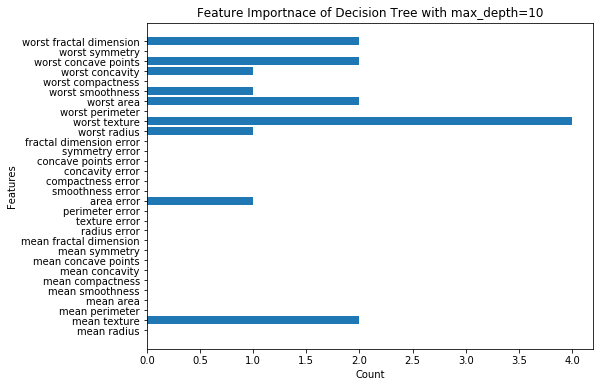

In [17]:
importances = clf_depth10.feature_importance
features = np.array(x_train.columns)
plt.figure(figsize=(8, 6))
plt.title('Feature Importnace of Decision Tree with max_depth=10')
plt.ylabel('Features')
plt.xlabel('Count')
plt.barh(features, importances)

## Question 4
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement two arguments for the Random Forest.

1. **N_estimators**: The number of trees in the forest. 
2. **Max_features**: The number of random select features to consider when looking for the best split
3. **Bootstrap**: Whether bootstrap samples are used when building tree


In [18]:
class RandomForest():
    def __init__(self, n_estimators, max_features, boostrap=True, criterion='gini', max_depth=None):
        self.n_estimators = n_estimators
        self.max_features = int(max_features)
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth

    def fit(self, X, y):
        rf_model = []
        for tree_id in range(self.n_estimators):
            data_length = X.shape[0]
            feature_length = X.shape[1]
            if self.boostrap is False:
                selected_features = np.random.choice(feature_length, self.max_features)
                filter_X = X[:, selected_features]
                # Build decision tree model than append to random forest model
                dt_model = DecisionTree(criterion=self.criterion, max_depth=self.max_depth)
                dt_model.fit(filter_X, y)
                rf_model.append([dt_model, selected_features])
            else:
                # Bootstrap data from randomly selecting with replacement
                selected_rows = np.random.choice(data_length, data_length, replace=True)
                ensemble_X = X[selected_rows, :]
                ensemble_y = y[selected_rows, :]
                # Randomly select max_features' features to build a tree
                selected_features = np.random.choice(feature_length, self.max_features)
                ensemble_filter_X = ensemble_X[:, selected_features]
                # Build decision tree model than append to random forest model
                dt_model = DecisionTree(criterion=self.criterion, max_depth=self.max_depth)
                dt_model.fit(ensemble_filter_X, ensemble_y)
                rf_model.append([dt_model, selected_features])
        self.rf_model = rf_model

    def predict(self, X):
        predict_class = []
        for row_id in range(len(X)):
            # Binary classification
            tree_vote = {0: 0, 1: 0}
            for tree_id in range(self.n_estimators):
                filter_X = X[row_id, self.rf_model[tree_id][1]]
                node = self.rf_model[tree_id][0].traverse(filter_X, self.rf_model[tree_id][0].tree_model)
                node_class = max(node, key=node.get)
                tree_vote[node_class] += 1
            predict_class.append(max(tree_vote, key=tree_vote.get))
        return np.array(predict_class)

    def evaluate(self, predicted, truth):
        correct = 0
        for i in range(len(predicted)):
            if predicted[i] == truth[i][0]:
                correct += 1
        print("Testing accuracy is: {} with {} / {}".format(correct / len(predicted), correct, len(predicted)))

### Question 4.1
Using Criterion=‘gini’, Max_depth=None, Max_features=sqrt(n_features), showing the accuracy score of test data by n_estimators=10 and n_estimators=100, respectively.


In [19]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_10tree.fit(x_train.values, y_train.values)
predict_class = clf_10tree.predict(x_test.values)
clf_10tree.evaluate(predict_class, y_test.values)

Testing accuracy is: 0.965034965034965 with 138 / 143


In [20]:
clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(x_train.shape[1]))
clf_100tree.fit(x_train.values, y_train.values)
predict_class = clf_100tree.predict(x_test.values)
clf_100tree.evaluate(predict_class, y_test.values)

Testing accuracy is: 0.9370629370629371 with 134 / 143


### Question 4.2
Using Criterion=‘gini’, Max_depth=None, N_estimators=10, showing the accuracy score of test data by Max_features=sqrt(n_features) and Max_features=n_features, respectively.


In [21]:
clf_all_features = RandomForest(n_estimators=10, max_features=x_train.shape[1])
clf_all_features.fit(x_train.values, y_train.values)
predict_class = clf_all_features.predict(x_test.values)
clf_all_features.evaluate(predict_class, y_test.values)

Testing accuracy is: 0.916083916083916 with 131 / 143


In [22]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_random_features.fit(x_train.values, y_train.values)
predict_class = clf_random_features.predict(x_test.values)
clf_random_features.evaluate(predict_class, y_test.values)

Testing accuracy is: 0.9230769230769231 with 132 / 143


- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 